In [1]:
# !pip install tensorflow==2.8.0

In [2]:
import gdown
file_id = '1xKJlWIbfSrPw6wvdFTBdaoStAyWjoqz8'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'KorSTS.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1xKJlWIbfSrPw6wvdFTBdaoStAyWjoqz8
To: /content/KorSTS.zip
100%|██████████| 438k/438k [00:00<00:00, 34.6MB/s]


'KorSTS.zip'

In [3]:
!unzip KorSTS.zip

Archive:  KorSTS.zip
  inflating: sts-test.tsv            
  inflating: sts-dev.tsv             
  inflating: sts-train.tsv           


In [4]:
!pip install mxnet
!pip install gluonnlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661657 sha256=ae41d118beb1699de6f6d6955e933db1704618570ff9cdf92be85b1447bcfd6e
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
# from gluonnlp.data import SentencepieceTokenizer

In [6]:
# BERT 모델
# 1. 양방향 학습... MASK(MLM) 처리 해서 마스킹된 단어를 예측 -> 다양한 위치에서 문맥정보를 학습
# 2. NSP(Next Sentence Prediction) : 두개의 문장을 입력으로 받음, 문장간의 관계를 이해한다.

In [7]:
train_data = pd.read_csv('sts-train.tsv', sep='\t',quoting=3)
dev_data = pd.read_csv('sts-dev.tsv', sep='\t',quoting=3)
test_data = pd.read_csv('sts-test.tsv', sep='\t',quoting=3)
train_data.head()

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.


In [8]:
train_data.shape

(5749, 7)

In [9]:
# 학습용 데이터셋
train_set = pd.Series(train_data['sentence1'].tolist() + train_data['sentence2'].tolist()).astype(str)
dev_set = pd.Series(dev_data['sentence1'].tolist() + dev_data['sentence2'].tolist()).astype(str)
test_set = pd.Series(test_data['sentence1'].tolist() + test_data['sentence2'].tolist()).astype(str)
train_set.shape

(11498,)

In [10]:
# 결측와 중복을 제거
print(f"중복데어터 : {train_set.duplicated().sum()}")
print(f"전체데터 개수 : {train_set.shape[0]}")
train_set = train_set.drop_duplicates()
print(f"중복제거 후 데이터 개수 : {train_set.shape[0]}")

중복데어터 : 1115
전체데터 개수 : 11498
중복제거 후 데이터 개수 : 10383


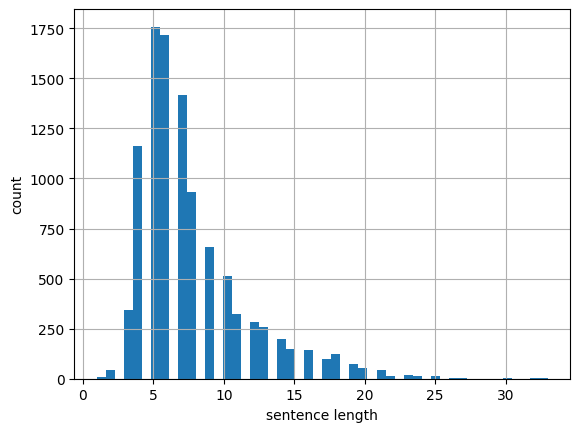

In [11]:
train_set.apply(lambda x : len(x.split())).hist(bins=50)
plt.xlabel('sentence length')
plt.ylabel('count')
plt.show()

In [12]:
# 사분위수
train_set.apply(lambda x : len(x.split())).describe()

,0
count,10383.000000
mean,7.717904
std,3.921041
min,1.000000
25%,5.000000
50%,7.000000
75%,9.000000
max,33.000000


In [13]:
# 토큰을 적용한 후의 각 문장의 토큰들의 길이
# 4분위 수


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


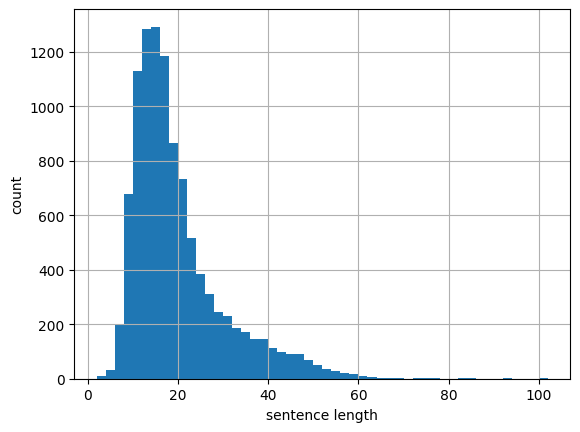

In [14]:
# bert 관련 토크나이저를 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
train_bert_tokenizer_counts = train_set.apply(lambda x : len(tokenizer.tokenize(x)))
train_bert_tokenizer_counts.hist(bins=50)
plt.xlabel('sentence length')
plt.ylabel('count')
plt.show()

In [15]:
# 토크나이져의 4분위수
train_bert_tokenizer_counts.describe()

,0
count,10383.000000
mean,19.370606
std,10.275411
min,2.000000
25%,12.000000
50%,16.000000
75%,23.000000
max,102.000000


In [16]:
p_85 = np.percentile(train_bert_tokenizer_counts, 85)
p_90 = np.percentile(train_bert_tokenizer_counts, 90)
p_95 = np.percentile(train_bert_tokenizer_counts, 95)
p_85, p_90,p_95

(29.0, 34.0, 42.0)

In [17]:
# 사전학습 모델 로드
from transformers import TFBertModel
import tensorflow as tf

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',cache_dir='bert_ckpt',do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
# 하이퍼 파라메터 정의
BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 42

In [20]:
tokenizer.all_special_tokens, tokenizer.all_special_ids

(['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'], [100, 102, 0, 101, 103])

In [21]:
# 우리가 로드한 사전학습 Bert모델은 다국어
kor_enc = tokenizer.tokenize('안녕하세요')
eng_enc = tokenizer.tokenize('Hello world good morning')
kor_enc, eng_enc

(['안', '##녕', '##하', '##세', '##요'], ['Hello', 'world', 'good', 'morning'])

In [22]:
tokenizer.convert_tokens_to_string(kor_enc), tokenizer.convert_tokens_to_string(eng_enc)

('안녕하세요', 'Hello world good morning')

In [23]:
kor_e = tokenizer.encode('안녕하세요',add_special_tokens=True)  # add_special_tokens=True
print(kor_e)
tokenizer.decode(kor_e)

[101, 9521, 118741, 35506, 24982, 48549, 102]


'[CLS] 안녕하세요 [SEP]'

In [24]:
# 두개의 문장을 입력으로 받아서 Bert 모델에 맞게 인코딩
def bert_tokenizer(sent1, sent2, MAX_LEN):
  encoded_dict =   tokenizer.encode_plus(
      text = sent1,
      text_pair = sent2,
      max_length = MAX_LEN,
      add_special_tokens = True,   # ex [CLS] 안녕하세요 [SEP]
      pad_to_max_length = True,   # 최대치보다 짧으면 0으로 패딩
      return_attention_mask = True  # 어텐션 마스크 생성
      ,truncation=True
  )
  input_id =  encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']
  return input_id, attention_mask, token_type_id

In [25]:
# 특수문자 제거  - 정규식
import re
def clean_text(sent):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)  # 한글과 공백을 제외한 모든 문자는 제거
  return sent_clean

input_ids = []
attention_maks = []
token_type_ids = []
data_labels = []

# 두개의 문장과 스코어를 Bert에 사전학습을 진행
# for sent1, sent2, score in zip(train_data['sentence1'], train_data['sentence2'], train_data['score']):
for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
  input_id, attention_mask, token_type_id =  bert_tokenizer(clean_text(sent1), clean_text(sent2), MAX_LEN)
  input_ids.append(input_id)
  attention_maks.append(attention_mask)
  token_type_ids.append(token_type_id)
  data_labels.append(score)

# numpy array
assert np.mean([len(word) for word in input_ids]) == MAX_LEN
train_input_ids = np.array(input_ids, dtype=int)
train_attention_maks = np.array(attention_maks, dtype=int)
train_token_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_maks,train_token_type_ids)
train_data_labels = np.array(data_labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowin

In [26]:
# 동일한 방식으로 Dev 데이터 array 변환까지 시행
dev_set.shape,test_set.shape

((3000,), (2758,))

In [27]:
input_ids = []
attention_maks = []
token_type_ids = []
data_labels = []
# 두개의 문장과 스코어를 Bert에 사전학습을 진행
# for sent1, sent2, score in zip(train_data['sentence1'], train_data['sentence2'], train_data['score']):
for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
  input_id, attention_mask, token_type_id =  bert_tokenizer(clean_text(sent1), clean_text(sent2), MAX_LEN)
  input_ids.append(input_id)
  attention_maks.append(attention_mask)
  token_type_ids.append(token_type_id)
  data_labels.append(score)
# numpy array
assert np.mean([len(word) for word in input_ids]) == MAX_LEN
dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_maks = np.array(attention_maks, dtype=int)
dev_token_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids,dev_attention_maks,dev_token_type_ids)
dev_data_labels = np.array(data_labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowin

In [28]:
len(train_data_labels), len(dev_data_labels)

(5749, 1500)

In [29]:
import gc
del train_data, dev_data
gc.collect()

0

In [30]:
# TF 의 모델클래스를 상속받아서 Bert모델의 회귀에 사용자 데이터를 적용한 클래스 생성
class TFBertForRegression(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):  # dir_path Bert의 캐쉬경로
    super(TFBertForRegression,self).__init__()
    # Bert 모델 로드
    self.bert = TFBertModel.from_pretrained(model_name, dir_path, from_pt=True)
    self.num_class = num_class
    self.drop = tf.keras.layers.Dropout(0.5)
    self.regressor = tf.keras.layers.Dense(self.num_class,
      kernel_initializer=tf.keras.initializers.TruncatedNormal(),
      name="regressor")
  def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
    # 모델 훈련
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
    # [0] : Sequence Output : 모든 입력토큰에 대한 벡터 (기본 BERT 모델기준 768차원)
    # 토큰수준의 타스크에 사용(개채명 인식, 문장 분류등.)
    # [1] : Pooled Output : [CLS] 토큰에 해당하는 벡터... 문장수준의 타스크에 사용(문장 분류, 회귀등)
    pooled_output = outputs[1]  # 두번재 값을 저장 : 입력문장을 요약한 벡터
    pooled_output = self.drop(pooled_output, training=training)
    logits = self.regressor(pooled_output) # 음수도 나올수 있음(소프트맥스를 통과하기 전)
    return logits

In [31]:
# 클래스 객체화
regression_model = TFBertForRegression(
    model_name='bert-base-multilingual-cased',
    dir_path='bert_ckpt',
    num_class=1
)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [32]:
# 평가함수로 결정계수
class R2Metric(tf.keras.metrics.Metric):
  def __init__(self, name='r2_score', **kwargs):
    super(R2Metric, self).__init__(name=name, **kwargs)
    self.y_true_list = []
    self.y_pred_list = []
  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.reshape(y_true, shape=[-1])
    y_pred = tf.reshape(y_pred, shape=[-1])
    self.y_true_list.append(y_true)
    self.y_pred_list.append(y_pred)
  def result(self):
    y_true = tf.concat(self.y_true_list, -1)
    y_pred = tf.concat(self.y_pred_list, -1)
    ss_total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    ss_residaul = tf.reduce_sum(tf.square(y_true - y_pred))
    r2 = 1 - (ss_residaul / ss_total + tf.keras.backend.epsilon())
    return r2
  def reset_state(self):
    self.y_true_list = []
    self.y_pred_list = []

In [33]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name="pearson_correlation", **kwargs):
        super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
        self.y_true_list = []
        self.y_pred_list = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)

    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_pred_list, -1)
        pearson_correlation = self.pearson(y_true, y_pred)

        return pearson_correlation

    def reset_states(self):
        self.y_true_list = []
        self.y_pred_list = []


    def pearson(self, true, pred):
        m_true = tf.reduce_mean(true)
        m_pred = tf.reduce_mean(pred)
        m_true, m_pred = true-m_true, pred-m_pred
        num = tf.reduce_sum(tf.multiply(m_true, m_pred))
        den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12
        return num / den


In [70]:
# 최적화 옵티마이져
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# 손실함수
loss = tf.keras.losses.Huber(delta = 1.0)
# 평가도구(함수)
metric = tf.keras.losses.MeanAbsoluteError()
# 컴파일
regression_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
# 콜백
earlystop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('regression_model.keras.h5', save_best_only=True,save_weights_only=True)

In [ ]:
# 학습진행
history = regression_model.fit(
    train_inputs,train_data_labels, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
    validation_data = (dev_inputs, dev_data_labels),callbacks=[earlystop_cb, checkpoint_cb]
)

Epoch 1/3


In [ ]:
print(history.history.keys())
plt.plot(np.log2( history.history['loss']))
plt.plot(np.log2(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'])

In [ ]:
# 베스트 모델 불러오기
regression_model.load_weights('regression_model.keras.h5')

In [62]:
input_ids = []
attention_maks = []
token_type_ids = []
data_labels = []
# 두개의 문장과 스코어를 Bert에 사전학습을 진행
# for sent1, sent2, score in zip(train_data['sentence1'], train_data['sentence2'], train_data['score']):
for sent1, sent2, score in test_data[['sentence1', 'sentence2', 'score']].values:
  input_id, attention_mask, token_type_id =  bert_tokenizer(clean_text(sent1), clean_text(sent2), MAX_LEN)
  input_ids.append(input_id)
  attention_maks.append(attention_mask)
  token_type_ids.append(token_type_id)
  data_labels.append(score)
# numpy array
assert np.mean([len(word) for word in input_ids]) == MAX_LEN
test_input_ids = np.array(input_ids, dtype=int)
test_attention_maks = np.array(attention_maks, dtype=int)
test_token_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids,test_attention_maks,test_token_type_ids)
test_data_labels = np.array(data_labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowin

In [63]:
del input_ids, attention_maks, token_type_ids, data_labels
gc.collect()

1499

In [64]:
result = regression_model.evaluate(test_inputs, test_data_labels,batch_size=BATCH_SIZE)
print(f'test data mse : {result}')

44/44 [==============================] - 4s 93ms/step - loss: 2.3971 - huber: 0.9005
test data mse : [2.3971376419067383, 0.9005081057548523]


In [ ]:
# 임의의 문장 두개
sentence1 = "한 여성이 다른 여성의 발목을 재고 있다."
sentence2 = "한 여자는 다른 여자의 발목을 측정한다."
# Bert 데이터 타입에 맞게 변경... 즉 토큰나이져
# 배열로 묶어주기
# 모델의 predict 수행
# 리턴 변수 :  input_id, attention_mask, token_type_id
bert_input = bert_tokenizer(sentence1, sentence2, MAX_LEN)
bert_input = (np.array([bert_input[0]]), np.array([bert_input[1]]), np.array([bert_input[2]]))
result = regression_model.predict(bert_input)
print(f'두 문장의 유사도 : {result}')

In [50]:
test_data.head()

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,24,2.5,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.
1,main-captions,MSRvid,2012test,33,3.6,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.
2,main-captions,MSRvid,2012test,45,5.0,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.
3,main-captions,MSRvid,2012test,63,4.2,한 남자가 오이를 자르고 있다.,한 남자가 오이를 자르고 있다.
4,main-captions,MSRvid,2012test,66,1.5,한 남자가 하프를 연주하고 있다.,한 남자가 키보드를 연주하고 있다.
